# Symmetrical choiceset:

We want to symmetrically sample both sides of the subjective equality point. 
That means having equal amount of trials in each side of the SV difference. 

This version of the code doesn't use python external libraries. The reason is to optimize the code to make it compatible with online based tasks that use Js. 

JS script data types we are going to use:
- Arrays: written with square brackets. Items are separated by commas. This is analogous to python lists. 

    ``` const cars = ["Saab", "Volvo", "BMW"]; ```
- Objects: JavaScript objects are written with curly braces {}.

Object properties are written as name:value pairs, separated by commas.

This is analogous to python dictionaries. I intend to use them to create the desired choicet. 

        const person = {firstName:"John", lastName:"Doe",  age:50, eyeColor:"blue"}

We use zip throughout. Looks like we can do something similar in Javascript

https://stackoverflow.com/questions/4856717/javascript-equivalent-of-pythons-zip-function

`zip= rows=>rows[0].map((_,c)=>rows.map(row=>row[c]))`

In [1]:
import math
import csv #This is the only library I will use. However, it is built in python. 

# post_mean_gain = [0.1096, 0.8382] # 23_IDM_ado_0150
# post_mean_gain = [0.7673, -0.3878] # 23_IDM_ado_0151
# post_mean_gain = [0.189, 0.269] # 23_IDM_ado_0152
# post_mean_gain = [0.935, -0.0889] # 23_IDM_ado_0153 (similar)
# post_mean_gain = [0.1998, 0.0973] # 23_IDM_ado_0154
# post_mean_gain = [0.3391, -0.893] # 23_IDM_ado_0155
# post_mean_gain = [0.2051, -0.316] # 23_IDM_ado_0156
post_mean_gain = [0.3, 0.867] # 23_IDM_ado_0157
post_mean_loss = [0.896596, -0.765]


The idea is to create an output CSV without using pandas :(
    We are going to do this by using lists and dicitonaries. The idea is to creaate the trials as lists of dictionries

With that, we can create the CSV at the end
```
Trials = 
{'category': ['Zero_Reward',  'Zero_Reward',..., 'Int_neg', 'Int_neg','Int_neg'],
 'p_reward': [0.75, 0.5,0.38, 0.25, 0.13, ..., 0.75 0.5, 0.38,0.25,0.13],
 'value_reward': [-0.0,  -5.71, ..., -22.453 , -34.884],
 'ambiguity': [0.0, 0.0,0.0  0.24, 0.5, 0.74, 0.0, 0.0],
 'SV_reward': [0.0, -5.551115123125783e-17, -1.813, -3.62, -2.222, -4.532],
 'SV_New_Safe': [-2.719, -1.8130],
 'value_lott_SE': [-12.723, -12.723, -12.72,
  'value_safe': [-7.20, -0.226,  -2.995, -2.7-2.51]
 }
```

# 1. Input: ADO parameters

In [2]:
alpha_pos, beta_pos = post_mean_gain[0], post_mean_gain[1] #parameters for gains
alpha_neg, beta_neg = post_mean_loss[0], post_mean_loss[1] #parameters for losses

### Parameters varaibles needed

In [3]:
#Declare the variables
p_options = [0.75, 0.5, 0.38, 0.25, 0.13]
amb_options = [0.24, 0.5, 0.74]
A_null = 0.0 # no ambiguity
Vmax = 50.0 #The maximum amount we can pay to participants
Vmin = -50.0 #The minimum amount we can take from participants
# Vsafe_pos = 5.0 # The old safe option in positive trials
# Vsafe_neg = -5.0 # The old safe option in negative trials

#First, we create an empty dictionary that we will populate with the trials info. 

empty_trials = { #An indivual trial consists of the values with the same index in the different lists
  'category': [],
  'p_reward': [],
  'ambiguity': [],
  'value_reward': [],
  'SV_reward': [],
  'value_safe': [],
  'SV_safe': []
}
# used to organize the dictionary by keys
ordered_keys = empty_trials.keys()

### useful functions

In [4]:
def flatten(l):
    flat_list = []
    for sublist in l:
        for item in sublist:
            flat_list = flat_list + [item]
    return flat_list

def order_keys(dict,keys):
    ordered_dict = {}
    for k in keys:
        if k in dict.keys():
            ordered_dict[k] = dict[k]
    return ordered_dict

def round_number(number):
    number_to_50 = round(number*2) / 2
    if number_to_50 == 0:
        return 0.50
    else:
        return number_to_50
    
def round_to_50(dict):
    cols = ['value_safe','value_reward']
    for c in cols:
        rounded_col = []
        for v in dict[c]:
            rounded_col = rounded_col + [round_number(v)]
        dict[c] = rounded_col
    return dict

def value_repeat(value,length):
    list_repeat = []
    for i in range(length):
        list_repeat = list_repeat + [value]
    return list_repeat

def dict_merge(list_dict):
   merged_dict = list_dict[0].copy()
   for d in list_dict[1:]:
     for key, value in  d.items():
        merged_dict[key] = merged_dict[key] + value      
   return merged_dict




### CRDM functions defined 

functions are called below to create three portions: extreme, centered subjective equality, intermediate

In [5]:
##FUNCTIONS

#Create the extreme positive gains and losses
def get_extr_rows(p_options, domain='gain'):
    extr = empty_trials.copy()
    category = 'Extr_pos' if domain == 'gain' else 'Extr_neg'
    V=value_repeat(Vmax,len(p_options)) #A list of values with the same length as our p_options
    if domain == 'loss':
            V = value_repeat(Vmin,len(p_options))
    extr = {
            'category': value_repeat(category,len(p_options)),
            'p_reward': p_options,
            'ambiguity': value_repeat(0.0,len(p_options)),
            'value_reward': V,
        }
    return extr

#Add ambiguity
def add_ambig(trials,amb_options):
    prob_amb=0.50
    V = value_repeat(trials['value_reward'][0],len(amb_options))
    amb_trials = {
            'p_reward': value_repeat(prob_amb,len(amb_options)),
            'value_reward': V,
            'ambiguity': amb_options,
        }
    final_dict = {}
    for k in set(trials) & set(amb_trials):
        final_dict[k] = trials[k] + amb_trials[k]
    final_dict['category'] = value_repeat(trials['category'][0],len(final_dict['value_reward'][:]))
    return final_dict

#Add Subjective value given participant's alpha and beta
def add_SV(trials, alpha, beta, domain='gain'):
    Amp = 1.0
    if domain == 'loss':
          Amp = -1.0
    sv_reward = []
    for idx in range(len(trials['p_reward'])):
        p = trials['p_reward'][idx]
        v = trials['value_reward'][idx]
        A = trials['ambiguity'][idx]
        sv_reward = sv_reward + [(p -(beta*A/2)) * (Amp*abs(v) ** alpha)]
    trials['SV_reward'] = sv_reward
    return trials  

# Add Vsafe and its subjective value     
def add_Vsafe(trials, alpha,beta, domain = 'gain'):
    Amp = 1.0 
    if domain == 'loss':
        Amp = -1.0
    sv_safe = []
    value_safe = []
    for sv in trials['SV_reward']:
        sv_safe = sv_safe + [sv/2]
        value_safe = value_safe + [Amp*(abs(sv))**(1/alpha)]
    trials['SV_safe'] = sv_safe
    trials['value_safe'] = value_safe
    return trials

def get_SE_trials (trials, alpha, beta, domain = 'gains'):
    SE_trials = {}
    SE_trials['category'] = value_repeat('SE_pos',len(trials['SV_safe']))
    Amp = 1.0 
    if domain == 'loss':
        Amp = -1.0
        SE_trials['category'] = value_repeat('SE_neg',len(trials['SV_safe']))

    SE_trials['p_reward'] = trials['p_reward']
    SE_trials['ambiguity'] = trials['ambiguity']
    SE_trials['SV_safe'] = trials['SV_safe']
    sv_reward = []
    value_safe = []
    value_reward = []
    for idx in range(len(trials['SV_reward'])):
        svr = trials['SV_reward'][idx]
        sv_reward = sv_reward + [svr/2]

        svf = trials['SV_safe'][idx]
        value_safe = value_safe + [Amp*(abs(svf))**(1/alpha)]

        p = trials['p_reward'][idx]
        A = trials['ambiguity'][idx]
        value_reward = value_reward + [Amp*(abs(svf)/((p) - (beta*A/2)))**(1/alpha)]

    SE_trials['SV_reward'] = sv_reward
    SE_trials['value_safe'] = value_safe
    SE_trials['value_reward'] = value_reward
    return SE_trials

def get_cent_SE_trials(SE_trials,  alpha, beta, domain = 'gain'):
    cent_SE= {}
    # SE = SE_trials
    cent_SE_trial_plus2 = SE_trials
    cent_SE_trial_minus2 = SE_trials
    value_reward_plus2 = []
    value_reward_minus2 = []
    for idx in range(len(cent_SE_trial_plus2['value_reward'])):
        value_reward = cent_SE_trial_plus2['value_reward'][idx]
        value_reward_plus2 = value_reward_plus2 + [value_reward + 2.0]
        value_reward_minus2 = value_reward_minus2 + [value_reward - 2.0]
    cent_SE_trial_plus2['value_reward'] = value_reward_plus2
    cent_SE_trial_minus2['value_reward'] = value_reward_minus2

    # Merge dictionaries while keeping values in lists
    # cent_SE = dict_merge([SE_trials,cent_SE_trial_plus2,cent_SE_trial_minus2])
    cent_SE = dict_merge([SE_trials])
    
    Amp = 1.0 
    cent_SE['category'] = value_repeat('Cent_SE_pos',len(cent_SE['value_reward']))
    if domain == 'loss':
        Amp = -1.0
        cent_SE['category'] = value_repeat('Cent_SE_neg',len(cent_SE['value_reward']))
    sv_reward = []
    for idx in range(len(cent_SE['p_reward'])):
        p = cent_SE['p_reward'][idx]
        A = cent_SE['ambiguity'][idx]
        v = cent_SE['value_reward'][idx]
        sv_reward = sv_reward + [(p-beta*A/2)*Amp*abs(v)**alpha]
    cent_SE['SV_reward'] = sv_reward

    return cent_SE

def get_interm_trials(rows_extr, alpha, beta,num_steps=2, domain='gain'):
    full_int = {}
    
    SV_step = []
    for idx in range(len(rows_extr['SV_reward'])):
        reward = rows_extr['SV_reward'][idx]
        safe = rows_extr['SV_safe'][idx]
        SV_step = SV_step + [(reward-safe)/(num_steps + 1)]
    
    list_x = []
    for i in range(-num_steps-1,num_steps+1):
        if i !=0:
            list_x = list_x + [i]

    list_dict = []
    for x in list_x:
        interm = {}
        Amp = 1.0
        category = 'Int_pos'
        if domain == 'loss':
            Amp = -1.0
            category = 'Int'
        if x == -num_steps-1:
            category = 'Zero_Reward'
        interm['category'] = value_repeat(category,len(rows_extr['category']))
        interm['p_reward'] = rows_extr['p_reward']
        interm['ambiguity'] = rows_extr['ambiguity']
        sv_reward = []
        for idx in range(len(SV_step)):
            safe = rows_extr['SV_safe'][idx]
            step = SV_step[idx]
            sv_reward = sv_reward + [safe+x*step]
        interm['SV_reward'] = sv_reward
        interm['value_safe'] = rows_extr['value_safe']
        interm['SV_safe'] = rows_extr['SV_safe']

        value_reward = []
        for idx in range(len(interm['SV_reward'])):
            sv = interm['SV_reward'][idx]
            p = interm['p_reward'][idx]
            A = interm['ambiguity'][idx]
            value_reward = value_reward + [Amp*(abs(sv)/((p) - (beta*A/2)))**(1/alpha)]
        interm['value_reward'] = value_reward
        list_dict = list_dict + [interm]
    
    for k in list_dict[0]:
        dict_list = []
        for d in list_dict:
            dict_list = dict_list + [d[k]]
        full_int[k] = flatten(dict_list)
    
    return full_int


## Convert column names and make it look like CRDM choice set

In [6]:
# we can use Math.random
import numpy as np
def gen_random_list(len):
    random_list = []
    for i in range(len):
        random_list = random_list + [round(np.random.rand())]
    return random_list

def pavlovia_dict(dict,domain='gain'):
    nb_trials = len(dict['value_safe'])
    column_order = ['crdm_sure_amt', 'crdm_sure_p', 'crdm_lott_top', 'crdm_lott_bot', 'crdm_lott_p', 
                    'crdm_amb_lev', 'crdm_domain', 'crdm_img', 'crdm_nonzero_side']

    crdm_trials = {}
    crdm_trials['crdm_sure_amt'] = dict['value_safe']
    crdm_trials['crdm_sure_p'] = value_repeat(100,nb_trials)

    # assign randomly top or bottom
    random_list = gen_random_list(nb_trials)
    crdm_lott_top = []
    crdm_lott_bot = []
    crdm_nonzero_side = []
    for idx in range(len(random_list)):
        v = dict['value_reward'][idx]
        loc = random_list[idx]
        if loc == 1:
            crdm_lott_top = crdm_lott_top + [v]
            crdm_lott_bot = crdm_lott_bot + [0]
            crdm_nonzero_side = crdm_nonzero_side + ['top']
        elif loc == 0:
            crdm_lott_top = crdm_lott_top + [0]
            crdm_lott_bot = crdm_lott_bot + [v]
            crdm_nonzero_side = crdm_nonzero_side + ['bottom']

    crdm_trials['crdm_lott_top'] = crdm_lott_top
    crdm_trials['crdm_lott_bot'] = crdm_lott_bot
    crdm_trials['crdm_nonzero_side'] = crdm_nonzero_side
    
    crdm_lott_p = []
    crdm_amb_lev = []
    for idx in range(len(dict['p_reward'])):
        p = dict['p_reward'][idx]
        crdm_lott_p = crdm_lott_p + [round(100*p)]

        a = dict['ambiguity'][idx]
        crdm_amb_lev = crdm_amb_lev + [round(100*a)]

    crdm_trials['crdm_lott_p'] = crdm_lott_p
    crdm_trials['crdm_amb_lev'] = crdm_amb_lev
    
    crdm_img = []
    for idx in range(len(crdm_trials['crdm_lott_p'])):
        p = crdm_trials['crdm_lott_p'][idx]
        a = crdm_trials['crdm_amb_lev'][idx]
        side = crdm_trials['crdm_nonzero_side'][idx]
        if a > 0:
            crdm_img = crdm_img + ['ambig_{}.bmp'.format(a)]
        elif side == 'top':
            crdm_img = crdm_img + ['risk_red_{}.bmp'.format(p)]
        elif side == 'bottom':
            crdm_img = crdm_img + ['risk_blue_{}.bmp'.format(p)]

    crdm_trials['crdm_img'] = crdm_img
    crdm_trials['crdm_domain'] = value_repeat(domain,nb_trials)
    crdm_trials = order_keys(crdm_trials,column_order)
    return crdm_trials



### Calling the functions to make the three portions of the trials


In [7]:
def get_trials(p_options,amb_options,alpha,beta,ordered_keys=[],domain='gain',verbose=False):
    rows_extr = get_extr_rows(p_options, domain = domain)
    rows_extr = add_ambig(rows_extr,amb_options)
    rows_extr = add_SV(rows_extr, alpha,beta, domain = domain)
    rows_extr = add_Vsafe(rows_extr, alpha,beta,domain=domain)
    rows_extr = order_keys(rows_extr,ordered_keys)

    #Neg Safe options dictionary. is this necessary? 
    # safe_neg = get_safe_trials(rows_extr, alpha, beta, domain= domain)

    #Subjective equality trials SE_neg = get_SE_trials(rows_extr, alpha, beta, domain='loss')
    # cent contains SE_neg within it... SE_neg not needed later on
    cent = get_cent_SE_trials(get_SE_trials(rows_extr, alpha, beta, domain=domain), alpha, beta, domain = domain)
    cent = order_keys(cent,ordered_keys)

    interm = get_interm_trials(rows_extr, alpha, beta,domain=domain)
    interm = order_keys(interm,ordered_keys)
    if verbose:
        print(rows_extr)
        print(cent)
        print(interm)

    # Concat dictionaries into one
    trials_list = []
    trials_list.append(rows_extr)
    trials_list.append(interm)
    trials_list.append(cent)
    trials = dict_merge(trials_list)
    # {k :flatten([d[k] for d in trials_list]) for k in trials_list[0]}
    
    return round_to_50(trials)


### Output CSV

In [8]:
def get_element_by_col(my_dict,row_nb):
    row_dict=dict.fromkeys(my_dict.keys())
    for c in my_dict.keys():
        row_dict[c] = my_dict[c][row_nb]
    return row_dict

def convert_list_dict(my_dict):
    my_list_dict = []
    nb_trials = len(my_dict[next(iter(my_dict))])
    for row_nb in range(nb_trials):
        row_dict = dict.fromkeys(my_dict.keys())
        row_dict = get_element_by_col(my_dict,row_nb)
        my_list_dict = my_list_dict + [row_dict]
    return my_list_dict

In [9]:
def save_to_csv(crdm_trials,fn='/tmp/out.csv'):
    crdm_trials_list = convert_list_dict(crdm_trials)
    
    print('Saving to : {}'.format(fn))
    # Open a file in write mode.
    with open(fn, 'w') as f:
        # Write all the dictionary keys in a file with commas separated.
        f.write(','.join(crdm_trials_list[0].keys()))
        f.write('\n') # Add a new line
        for row in crdm_trials_list:
            # Write the values in a row.
            f.write(','.join(str(x) for x in row.values()))
            f.write('\n') # Add a new line


# void_main() style part of the script

In [10]:
# round value_reward and vallue_safe to nearest 50 cents
trials_gain = get_trials(p_options,amb_options,alpha_pos,beta_pos,ordered_keys=ordered_keys,domain='gain',verbose=False)
trials_loss = get_trials(p_options,amb_options,alpha_neg,beta_neg,ordered_keys=ordered_keys,domain='loss',verbose=False)

crdm_trials_gain = pavlovia_dict(trials_gain,domain='gain')
crdm_trials_loss = pavlovia_dict(trials_loss,domain='loss')
crdm_trials = dict_merge([crdm_trials_gain,crdm_trials_loss])
# {k :flatten([d[k] for d in [crdm_trials_gain,crdm_trials_loss]]) for k in crdm_trials_gain}

fn = 'crdm_csv/crdm_trials_online.csv'
save_to_csv(crdm_trials,fn = fn)


Saving to : crdm_csv/crdm_trials_online.csv


## (Visualization) Just for checking Mandy!

,category,p_reward,ambiguity,value_reward,SV_reward,value_safe,SV_safe
0,Extr_pos,0.75,0.00,50.0,2.425226e+00,19.0,1.212613
1,Extr_pos,0.50,0.00,50.0,1.616818e+00,5.0,0.808409
2,Extr_pos,0.38,0.00,50.0,1.228781e+00,2.0,0.614391
3,Extr_pos,0.25,0.00,50.0,8.084088e-01,0.5,0.404204
4,Extr_pos,0.13,0.00,50.0,4.203726e-01,0.5,0.210186
5,Extr_pos,0.50,0.24,50.0,1.280390e+00,2.5,0.640195
6,Extr_pos,0.50,0.50,50.0,9.159271e-01,0.5,0.457964
7,Extr_pos,0.50,0.74,50.0,5.794997e-01,0.5,0.289750
8,Zero_Reward,0.75,0.00,0.5,0.000000e+00,19.0,1.212613
9,Zero_Reward,0.50,0.00,0.5,0.000000e+00,5.0,0.808409


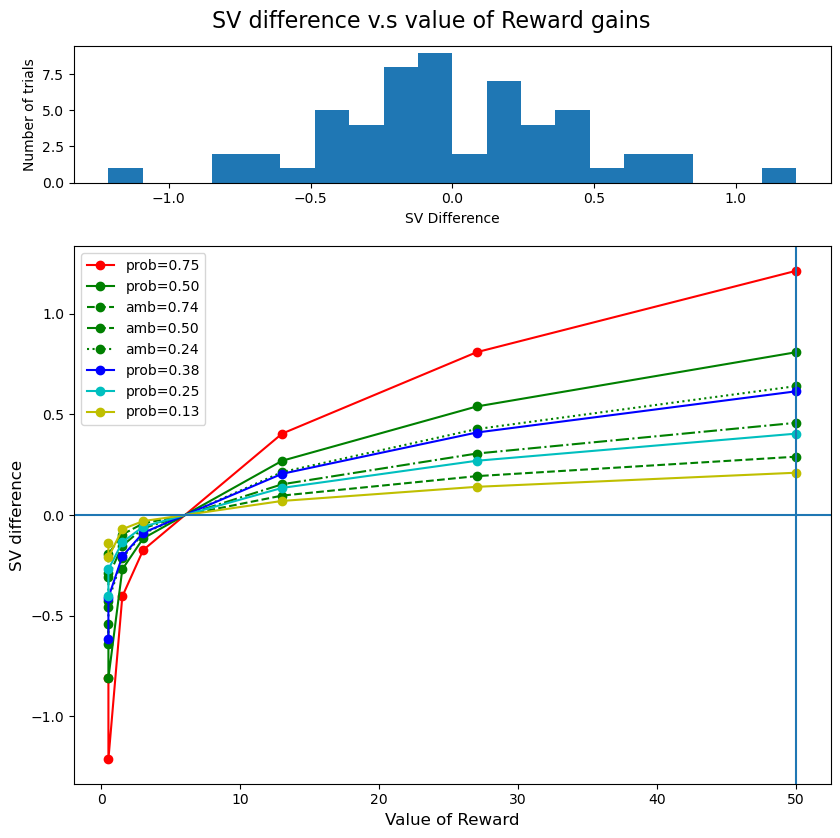

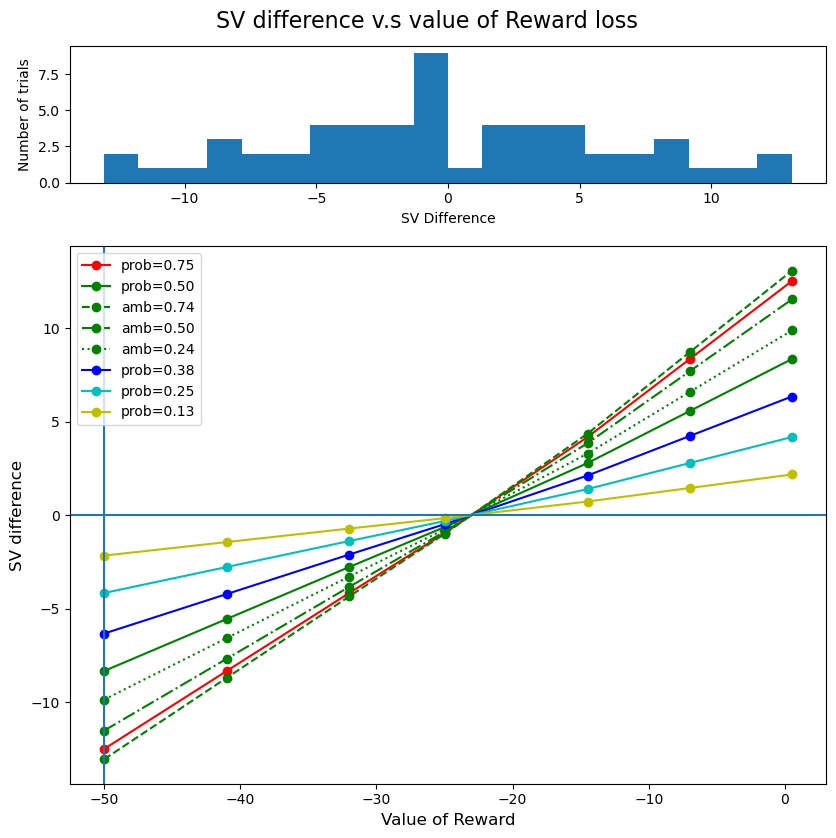

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def scatter_hist(x, y, ax, ax_histy,xlabel='',ylabel='',title=''): #This functions creates a scatter plot with histograms at its sides
	#ax.scatter(x, y)
	ax.set_xlabel(xlabel,fontsize=12) #Creates the subplots
	ax.set_ylabel(ylabel,fontsize=12)
	plt.suptitle(title,fontsize=16, ha='center')
	#ax_histx.hist(x,bins=20)
	ax_histy.hist(y, bins=20)
	ax_histy.set_xlabel('SV Difference')
	ax_histy.set_ylabel('Number of trials')
	plt.tight_layout()


def setup_fig_ax():  #Setting the axis

	fig = plt.figure(figsize=(8.5,8.5))
	gs = GridSpec(4, 3)

	ax = fig.add_subplot(gs[1:4, 0:3])
	ax_histy = fig.add_subplot(gs[0,0:3])
	#ax_histx = fig.add_subplot(gs[1:4, 3])
	#ax_histx.tick_params(axis="x", labelbottom=False)
	ax_histy.tick_params(axis="y")
 	
	#Adjust spacing around subplots
	#plt.subplots_adjust(top=1.4, bottom=0.15, left=0.15, right=0.9)
	
	return ax, ax_histy

def plot_scatter_hist(df,xvline=50,trials='gains'):

	# delta SV v.s value_reward
	df['deltaSV'] = df['SV_reward']-df['SV_safe']
	x,y = df['value_reward'],df['deltaSV'] 
	ax,ax_histy = setup_fig_ax()

	scatter_hist(x,y,ax,ax_histy,  
		xlabel='Value of Reward',
		ylabel= 'SV difference',
		title= 'SV difference v.s value of Reward {}'.format(trials))

	colors = ['r','g','b','c','y','m','k']
	amb_line = ['--','-.',':']
	df = df.sort_values('value_reward')

	for i,p in enumerate(reversed(sorted(df['p_reward'].unique()))): #A scatter plot for each probability level
		df_p = df.loc[(df['p_reward']==p) & (df['ambiguity']==A_null)]
		x,y = df_p['value_reward'],df_p['deltaSV']
		ax.plot(x, y,'{}o-'.format(colors[i]),label='prob={0:0.2f}'.format(p)) #The plot conecting prob levels
		if p==0.50:
			for j,A in enumerate(reversed(sorted(df['ambiguity'].unique()))):
				if A==0:
					continue
				df_A = df.loc[(df['p_reward']==p) & (df['ambiguity']==A)]
				x,y = df_A['value_reward'],df_A['deltaSV']
				ax.plot(x, y,'{0}o{1}'.format(colors[i],amb_line[j]),label='amb={0:0.2f}'.format(A)) #The plot conecting prob levels
				
		

	# ax.plot([50],[],'r-')
	ax.axvline(x=xvline)
	# ax.plot([-50,-50],[-10,10],'r-')
	ax.axhline(y=0)
	# ax.plot([0,50],[0,0],'k--')
	ax.legend(loc="upper left")

display(pd.DataFrame.from_dict(trials_gain))
plot_scatter_hist(pd.DataFrame.from_dict(trials_gain),xvline=50)
plot_scatter_hist(pd.DataFrame.from_dict(trials_loss),xvline=-50,trials='loss')
 